
# Amazon Fine Food Reviews: Exploratory Analysis

## Introduction

### Initial goals

1. Perform some basic exploratory analysis to better understand reviews
2. What's in a review? Is it positive or negative?
3. What relationships exist between factors?

### Data Extraction  

* Data source:[Nesta CMS] (https://www.kaggle.com/snap/amazon-fine-food-reviews)
* About the data attributes
1.Score(Rating 1-5 stars)
2.The reivew
3.A summary of the review
4.Number of users who found the review helpful
5.Number of users who indicated whether they found the review helpful
6.Timestamp for the review
7.Unqiue identifier for the user
8.Unique identifier for the product

All data in one excel file.568,454 food reviews Amazon users left up to October 2012.


In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sqlite3 as sql
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import statsmodels.api as smf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from patsy import dmatrices


#retrieve data from dropbox file
df = pd.read_csv('https://www.dropbox.com/s/w5kkg7svxk7ssec/Reviews.csv?dl=1')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [2]:
# observing the shape
df.shape

(568454, 10)

In [3]:
# check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568438 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568427 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## Exploratory analysis

###  Distribution of ratings
* It shows that 5 star reviews consititute a large proportion, the next prevalent rating is 4-stars.

C:\Users\SabrinaXie\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


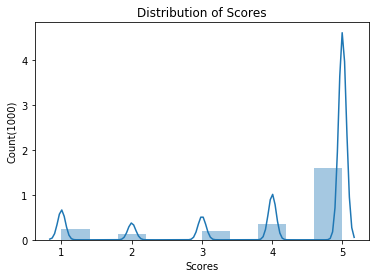

In [4]:
sns.distplot(df['Score'],bins=10)
plt.xlabel('Scores')
plt.ylabel('Count(1000)')
plt.title('Distribution of Scores')
plt.show()


### How many reviews are positive?

* Score >3 then 'positive',Score < 3 then 'negative', Score = 3 then 'neutral' 
* Posititive reviews are very common 

C:\Users\SabrinaXie\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


positive    443777
negative     82037
neutral      42640
Name: Positivity, dtype: int64

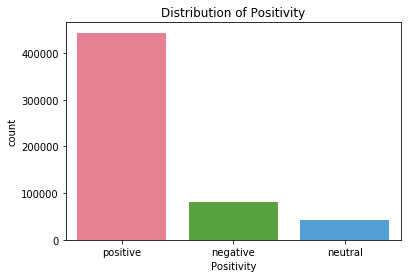

In [12]:
df1=df[['UserId','HelpfulnessNumerator','HelpfulnessDenominator', 'Summary','Text','Score']]
df1['Positivity']= df1['Score'].apply(lambda score: "positive" if score >3 else "negative" if score <3 else "neutral")

# plot the count for "Positivity"
sns.countplot(x='Positivity',data = df1,palette="husl")
plt.title('Distribution of Positivity')
df1['Positivity'].value_counts()

### How many reviews are helpful? 

* Among all reviews, almost half are not voted at all. 
* For voted reviews, helpful reviews are the most common.

C:\Users\SabrinaXie\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


No Indication    270052
>75%             202836
25-75%            57286
<25%              38280
Name: Helpfulness, dtype: int64

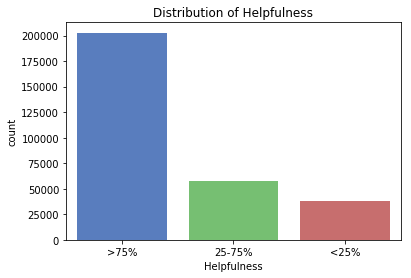

In [13]:
# check the value count for "helpfulness" 

df1['Helpfulness']= (df1["HelpfulnessNumerator"]/df1["HelpfulnessDenominator"]).apply\
(lambda n:">75%" if n > 0.75 else ("25-75%" if n >= 0.25 and n<=0.75 else ("<25%" if n<0.25 else "No Indication")))
df1['Helpfulness'].value_counts()
sns.countplot(x='Helpfulness',order=['>75%',"25-75%",'<25%'],data = df1,palette="muted")
plt.title('Distribution of Helpfulness') 
df1['Helpfulness'].value_counts()


### How do ratings affect helpfulness?

* The reviews become more helpful as the rating becomes more positive.

Text(0.5,1,'Helpfulness by Scores')

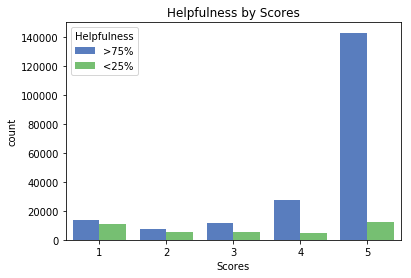

In [14]:
sns.countplot(x="Score", hue="Helpfulness",hue_order=['>75%', '<25%'], data= df1,palette="muted")
plt.xlabel('Scores')
plt.title('Helpfulness by Scores')

### Word count

* The more positive reviews had the lowest median word count.

C:\Users\SabrinaXie\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5,1,'Word Count by Rating')

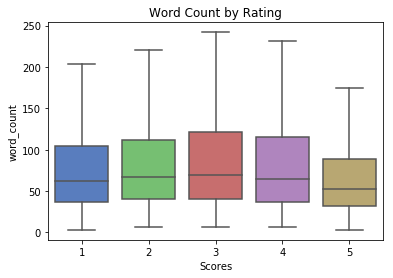

In [18]:
# word count
df1['word_count']= df1['Text'].apply(lambda text: len(text.split()))
# word count by score
sns.boxplot(x="Score", y='word_count',data= df1,palette="muted",showfliers=False)
plt.xlabel('Scores')
plt.title('Word Count by Rating')

### How does word count relate to helpfulness ?

* Helpful reviews and not helpful reviews have a similar distribution at the greatest concentration counts.
* Helpful reviews tend to have longer reviews compared to not helpful reviews.

(-30, 500)

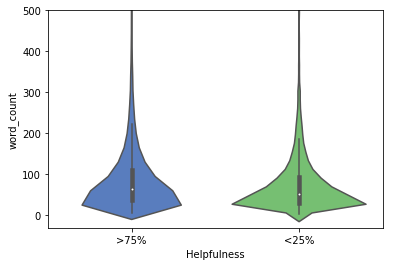

In [21]:
sns.violinplot(x="Helpfulness", y="word_count",order= ['>75%',"<25%"], data= df1,palette="muted")
plt.ylim(-30,500)

## Model buidling 

In [22]:
 
df2 = df1[['UserId','Summary','Text','Positivity']]
total_size = len(df2)
print 'len df2 is %d' % len(df2)


len df2 is 568454


In [59]:
# remove all 'neutral' values
data= df2[df2.Positivity!= 'neutral']
data.Positivity.replace(['positive', 'negative'], [1, 0], inplace=True)

# Memory error 
data=data[1:5000]
data.shape



(4999, 4)

In [44]:
# countvectorizer converts a collection of text documents into a matrix of token counts(see how often each word occurs)
#  convert the text document into a matrix of token counts
vect = CountVectorizer(analyzer = 'word',
    lowercase = False)
features = vect.fit_transform(
    data.Text
)

# for easy usage
features_nd = features.toarray() 



In [45]:
# split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(
        features_nd, 
        data.Positivity,
        train_size=0.80, 
        )

C:\Users\SabrinaXie\Anaconda2\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Models
Here I will implement various models and comparing their accuracies. 

* Naive Bayes
* Logistic Regression
* Random Forest


In [46]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,y_train)
#make predictions using vect_test
predictions = nb.predict(X_test)
print('AUC: ', roc_auc_score(y_test, predictions))



('AUC: ', 0.6632181714067571)


In [47]:

# logistic Regression - train logistic regression classifier based on matrix X_train
from sklearn.linear_model import LogisticRegression
model= LogisticRegression()
model.fit(X_train,y_train)
# make prediction using X_test and compute AUC
predictions = model.predict(X_test)
print('AUC: ', roc_auc_score(y_test, predictions))



('AUC: ', 0.7443977858369918)


In [48]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train,y_train)
# make prediction using X_test and compute AUC
predictions = model.predict(X_test)
print('AUC: ', roc_auc_score(y_test, predictions))



('AUC: ', 0.5855315899980913)


* We can see that Logistic regression model performed better than Naive Bayes and Random Forest

# Conclusions

* Positive reviews are very common
* Longer reviews are more helpful
* Positive reviews are shorter
* Positive reviews are more helpful 

The results are not bad but further analysis can be conduct to better understand how models make these predictions in order to improve the results.